# RTML Final Exam, Aug 2023

Welcome to the RTML final exam, version 2022!

Prepare your answer to each question, writing your answers directly in this notebook, print as PDF, and turn in via Google Classroom by the deadline.

You have 2.5 hours to complete the exam. Good luck!

## Question 1 (25 points)

In lab 7, you trained a Cycle GAN to map AIT ICT faces to celebrity faces and back.
Run a picture of your own face through the AIT-to-Celebrity generator you trained.
Show your code and result here.

In [1]:
# Your code here
# !env | grep proxy
# !unset https_proxy
# !unset http_proxy
# !python3 -m visdom.server

In [ ]:
####Test.py
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html

try:
    import wandb
except ImportError:
    print('Warning: wandb package cannot be found. The option "--use_wandb" will result in error.')


if __name__ == '__main__':
    opt = TestOptions().parse()  # get test options
    # hard-code some parameters for test
    opt.num_threads = 0   # test code only supports num_threads = 0
    opt.batch_size = 1    # test code only supports batch_size = 1
    opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
    opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
    opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
    dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
    model = create_model(opt)      # create a model given opt.model and other options
    model.setup(opt)               # regular setup: load and print networks; create schedulers

    # initialize logger
    if opt.use_wandb:
        wandb_run = wandb.init(project=opt.wandb_project_name, name=opt.name, config=opt) if not wandb.run else wandb.run
        wandb_run._label(repo='CycleGAN-and-pix2pix')

    # create a website
    web_dir = os.path.join(opt.results_dir, opt.name, '{}_{}'.format(opt.phase, opt.epoch))  # define the website directory
    if opt.load_iter > 0:  # load_iter is 0 by default
        web_dir = '{:s}_iter{:d}'.format(web_dir, opt.load_iter)
    print('creating web directory', web_dir)
    webpage = html.HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' % (opt.name, opt.phase, opt.epoch))
    # test with eval mode. This only affects layers like batchnorm and dropout.
    # For [pix2pix]: we use batchnorm and dropout in the original pix2pix. You can experiment it with and without eval() mode.
    # For [CycleGAN]: It should not affect CycleGAN as CycleGAN uses instancenorm without dropout.
    if opt.eval:
        model.eval()
    for i, data in enumerate(dataset):
        if i >= opt.num_test:  # only apply our model to opt.num_test images.
            break
        model.set_input(data)  # unpack data from data loader
        model.test()           # run inference
        visuals = model.get_current_visuals()  # get image results
        img_path = model.get_image_paths()     # get image paths
        if i % 5 == 0:  # save images to an HTML file
            print('processing (%04d)-th image... %s' % (i, img_path))
        save_images(webpage, visuals, img_path, aspect_ratio=opt.aspect_ratio, width=opt.display_winsize, use_wandb=opt.use_wandb)
    webpage.save()  # save the HTML

In [ ]:
!python3 test.py --dataroot /root/lab07/data/ait2celeba --name ait2celeb_cyclegan --model cycle_gan > output_todsavad2celeb.txt

In [ ]:
results = open("/root/lab07/pytorch-CycleGAN-and-pix2pix/output_todsavad2celeb.txt", "r")
print(results.read())

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /root/lab07/data/ait2celeba   	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

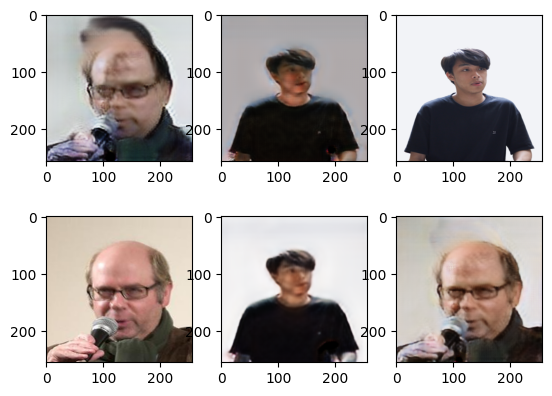

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.subplot(2, 3, 1)
img = mpimg.imread('/root/lab07/pytorch-CycleGAN-and-pix2pix/results/ait2celeb_cyclegan/test_latest/images/Todsavad_fake_A.png')
plt.imshow(img)
plt.subplot(2, 3, 2)
img = mpimg.imread('/root/lab07/pytorch-CycleGAN-and-pix2pix/results/ait2celeb_cyclegan/test_latest/images/Todsavad_fake_B.png')
plt.imshow(img)
plt.subplot(2, 3, 3)
img = mpimg.imread('/root/lab07/pytorch-CycleGAN-and-pix2pix/results/ait2celeb_cyclegan/test_latest/images/Todsavad_real_A.png')
plt.imshow(img)
plt.subplot(2, 3, 4)
img = mpimg.imread('/root/lab07/pytorch-CycleGAN-and-pix2pix/results/ait2celeb_cyclegan/test_latest/images/Todsavad_real_B.png')
plt.imshow(img)
plt.subplot(2, 3, 5)
img = mpimg.imread('/root/lab07/pytorch-CycleGAN-and-pix2pix/results/ait2celeb_cyclegan/test_latest/images/Todsavad_rec_A.png')
plt.imshow(img)
plt.subplot(2, 3, 6)
img = mpimg.imread('/root/lab07/pytorch-CycleGAN-and-pix2pix/results/ait2celeb_cyclegan/test_latest/images/Todsavad_rec_B.png')
plt.imshow(img)


## Question 2 (25 points)

In lab 12, you fine-tuned a ViT on the Kaggle Sports dataset. Load your fine tuned model and
run the image at
https://blog.roboflow.com/content/images/size/w1000/2022/11/Screen-Shot-2022-11-07-at-3.04.26-PM.webp
through the model. Provide your code and the output here. Does your model correctly
classify the image?

In [3]:
# Your code here

In [44]:
import os
import time
import torch
import torch.nn as nn
from torchvision.models import vit_b_16 as ViT, ViT_B_16_Weights

from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

from tqdm import tqdm

import os
os.environ['http_proxy']="http://192.41.170.23:3128"
os.environ['https_proxy']="http://192.41.170.23:3128"

# Set the GPU Device
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:1


In [45]:
model = ViT(weights=ViT_B_16_Weights.DEFAULT)

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f"{total_params/1000000}M")

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [46]:
# Changed to out_features = 100
model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=100, bias=True))

# Move the model to Device
model.to(device)
print("Classifier Head: ", model.heads)

Classifier Head:  Sequential(
  (0): Linear(in_features=768, out_features=100, bias=True)
)


In [47]:
print("### Start Loading Model ###")
model.load_state_dict(torch.load('./models/Ep.121.pth',  map_location=device))
print("### Finished Loading Model ###")

### Start Loading Model ###
### Finished Loading Model ###


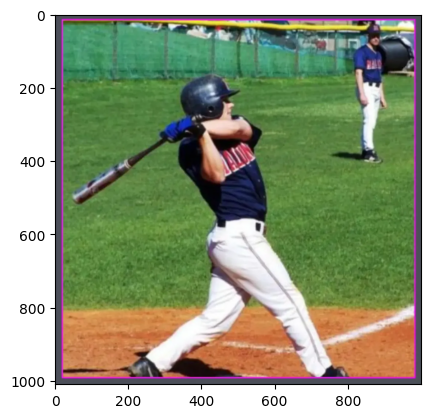

In [48]:
from PIL import Image
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

img = Image.open("picture.webp").convert('RGB')
plt.imshow(img)

In [49]:
class_file = '/root/Datasets/Sports/class_dict.csv'
class_df = pd.read_csv(class_file, usecols=['class_index', 'class'])
class_dict = { row[0]:row[1] for i, row in class_df.iterrows()}
print("class dict: ", class_dict)

class dict:  {0: 'air hockey', 1: 'ampute football', 2: 'archery', 3: 'arm wrestling', 4: 'axe throwing', 5: 'balance beam', 6: 'barell racing', 7: 'baseball', 8: 'basketball', 9: 'baton twirling', 10: 'bike polo', 11: 'billiards', 12: 'bmx', 13: 'bobsled', 14: 'bowling', 15: 'boxing', 16: 'bull riding', 17: 'bungee jumping', 18: 'canoe slamon', 19: 'cheerleading', 20: 'chuckwagon racing', 21: 'cricket', 22: 'croquet', 23: 'curling', 24: 'disc golf', 25: 'fencing', 26: 'field hockey', 27: 'figure skating men', 28: 'figure skating pairs', 29: 'figure skating women', 30: 'fly fishing', 31: 'football', 32: 'formula 1 racing', 33: 'frisbee', 34: 'gaga', 35: 'giant slalom', 36: 'golf', 37: 'hammer throw', 38: 'hang gliding', 39: 'harness racing', 40: 'high jump', 41: 'hockey', 42: 'horse jumping', 43: 'horse racing', 44: 'horseshoe pitching', 45: 'hurdles', 46: 'hydroplane racing', 47: 'ice climbing', 48: 'ice yachting', 49: 'jai alai', 50: 'javelin', 51: 'jousting', 52: 'judo', 53: 'lacros

In [59]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open("picture.webp").convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
  output = model(input_batch)

In [60]:
_, prediction = torch.max(output, dim=1)
print(f'Predict Result : {[class_dict[c] for c in prediction.tolist()]}')

Predict Result : ['baseball']


YES!!! The model is able to predict picture as baseball

## Question 3 (50 points)

In lab 13, you trained Deep RL methods such as REINFORCE and A2C on the Space Invaders
environment. Using the best approach you found for Space Invaders, re-train the same agent
on the Lunar Lander environment in Gymnasium. Your agent must use the image sequence as
input just like the Space Invaders agent.

You do not have to train your agent for a long time! Just show that it is learning the new
environment. Show the training progress (reward per episode) in a graph, and show a screen
shot of the agent playing the game.

### Reinforce

In [39]:
# Your code here
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import optim
from torch.distributions import Categorical

class Policy(nn.Module):
    def __init__(self, env):
        super(Policy, self).__init__()
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        
        self.affine1 = nn.Linear(self.n_inputs, 128)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(128, self.n_outputs)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)
    
    def select_action(self, state):
        state = torch.from_numpy(np.array(state)).float().unsqueeze(0)
        probs = self.forward(state)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.item()


Episode 10	Last reward: -218.64	Average reward: -79.20


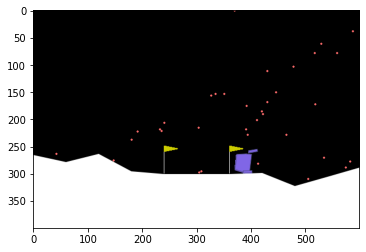

Episode 20	Last reward: -147.28	Average reward: -104.77


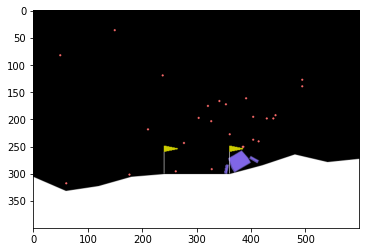

Episode 30	Last reward: -105.79	Average reward: -114.44


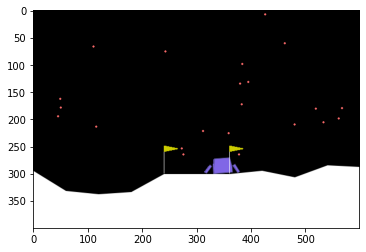

Episode 40	Last reward: -153.18	Average reward: -121.11


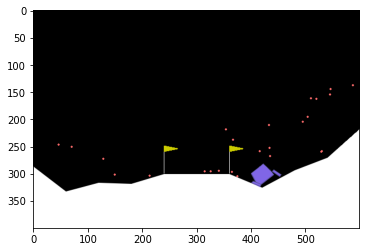

Episode 50	Last reward: -156.52	Average reward: -126.94


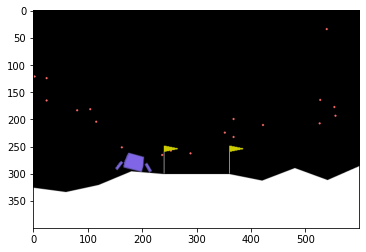

In [43]:
#RL environment parameters
gamma = 0.95
seed = 0
render = False
log_interval = 10

#Set up environment
env = gym.make("LunarLander-v2", render_mode="rgb_array")
env.reset(seed=seed)
torch.manual_seed(seed)

#Create out policy Network
policy = Policy(env)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()

# env.reset()
# x = env.render()
# print(x)

def finish_episode():
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]

from itertools import count
def reinforce():
    reward_list = []
    running_reward = 10
    for i_episode in count(1):
        (state, info), ep_reward = env.reset(), 0
        # print('Initial State', state)
        for t in range(1, 10000):  # Don't infinite loop while learning
            action = policy.select_action(state)
            state, reward, done, truncated, info = env.step(action)
            # print('New State', state)
            if render:
                env.render()
                # plt.imshow(env.render())
                # plt.show()
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        
        # calculate reward
        # It accepts a list of rewards for the whole episode and needs to calculate 
        # the discounted total reward for every step. To do this efficiently,
        # we calculate the reward from the end of the local reward list.
        # The last step of the episode will have the total reward equal to its local reward.
        # The step before the last will have the total reward of ep_reward + gamma * running_reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        reward_list.append(running_reward)
        finish_episode()
        if i_episode % log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
            plt.imshow(env.render())
            plt.show()
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break
        if i_episode == 50:
            break
        
    return reward_list
reward_list = reinforce()
env.close()

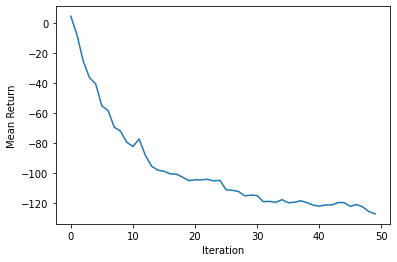

In [44]:
import matplotlib.pyplot as plt

plt.plot(reward_list)
plt.xlabel('Iteration')
plt.ylabel('Mean Return')
plt.savefig('reinforce_lunar.png', format='png', dpi=300)

### A2C

C:\Users\Guntsv\AppData\Local\Temp\ipykernel_25312\556535693.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(self.fc3(out))
C:\Users\Guntsv\AppData\Local\Temp\ipykernel_25312\556535693.py:111: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(actor_network.parameters(),0.5)
C:\Users\Guntsv\AppData\Local\Temp\ipykernel_25312\556535693.py:121: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(value_network.parameters(),0.5)


step: 50 test result: -136.63285661421682


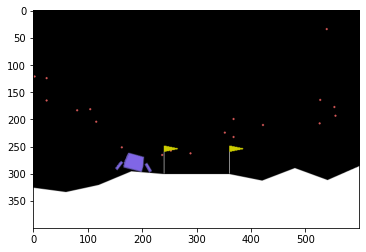

step: 100 test result: -120.54475817812298


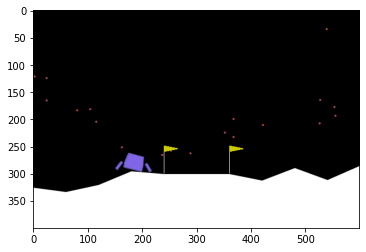

step: 150 test result: -125.4301397506933


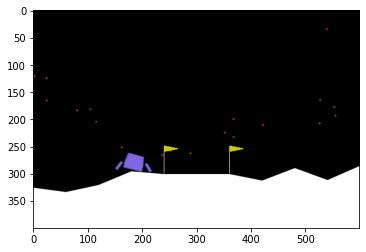

step: 200 test result: -168.4791636742405


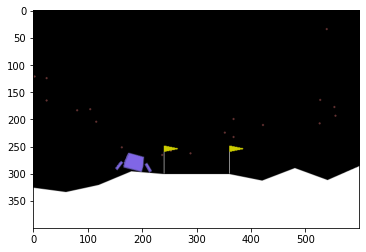

step: 250 test result: -115.67064958659103


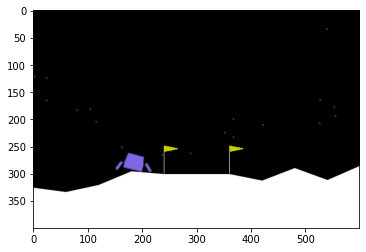

step: 300 test result: -130.03850273568983


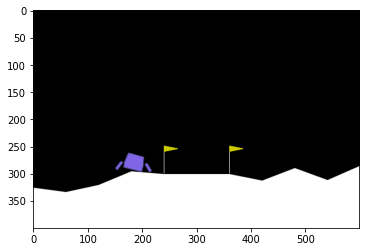

step: 350 test result: -104.30090104493402


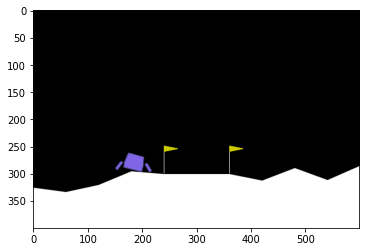

step: 400 test result: -113.68915627883719


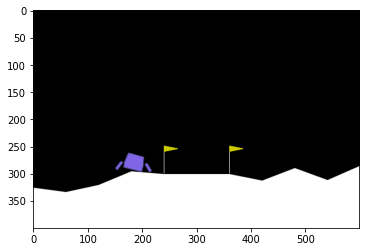

step: 450 test result: -127.7498527659659


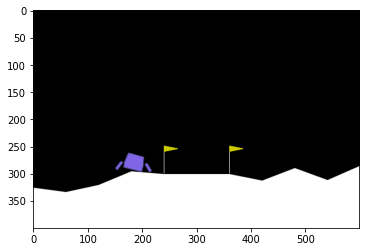

step: 500 test result: -116.87465870441561


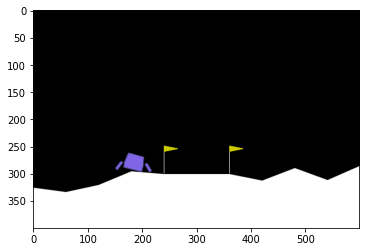

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import gymnasium as gym
from gym.wrappers import RecordVideo

class ActorNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,action_size)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.log_softmax(self.fc3(out))
        return out

class ValueNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

def roll_out(actor_network,task,sample_nums,value_network,init_state):
    #task.reset()
    states = []
    actions = []
    rewards = []
    is_done = False
    final_r = 0
    state = init_state

    for j in range(sample_nums):
        states.append(state)
        log_softmax_action = actor_network(torch.Tensor([state]))
        softmax_action = torch.exp(log_softmax_action)
        action = np.random.choice(ACTION_DIM,p=softmax_action.cpu().data.numpy()[0])
        one_hot_action = [int(k == action) for k in range(ACTION_DIM)]
        next_state,reward,done,_,_ = task.step(action)
        #fix_reward = -10 if done else 1
        actions.append(one_hot_action)
        rewards.append(reward)
        final_state = next_state
        state = next_state
        if done:
            is_done = True
            state, _ = task.reset()
            break
    if not is_done:
        final_r = value_network(torch.Tensor([final_state])).cpu().data.numpy()

    return states,actions,rewards,final_r,state

def discount_reward(r, gamma,final_r):
    discounted_r = np.zeros_like(r)
    running_add = final_r
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def A2C():
    # init a task generator for data fetching
    task = gym.make("LunarLander-v2")
    init_state, _ = task.reset()

    # init value network
    value_network = ValueNetwork(input_size = STATE_DIM,hidden_size = 40,output_size = 1)
    value_network_optim = torch.optim.Adam(value_network.parameters(),lr=0.01)

    # init actor network
    actor_network = ActorNetwork(STATE_DIM,40,ACTION_DIM)
    actor_network_optim = torch.optim.Adam(actor_network.parameters(),lr = 0.01)

    steps =[]
    task_episodes =[]
    test_results =[]

    for step in range(STEP):
        states, actions,rewards,final_r,current_state = roll_out(actor_network,task,SAMPLE_NUMS,value_network,init_state)
        init_state = current_state
        actions_var = torch.Tensor(actions).view(-1,ACTION_DIM)
        states_var = torch.Tensor(states).view(-1,STATE_DIM)

        # train actor network
        actor_network_optim.zero_grad()
        log_softmax_actions = actor_network(states_var)
        vs = value_network(states_var).detach()
        # calculate qs
        qs = torch.Tensor(discount_reward(rewards,0.99,final_r))

        advantages = qs - vs
        actor_network_loss = - torch.mean(torch.sum(log_softmax_actions*actions_var,1)* advantages)
        actor_network_loss.backward()
        torch.nn.utils.clip_grad_norm(actor_network.parameters(),0.5)
        actor_network_optim.step()

        # train value network
        value_network_optim.zero_grad()
        target_values = qs.unsqueeze(1)
        values = value_network(states_var)
        criterion = nn.MSELoss()
        value_network_loss = criterion(values,target_values)
        value_network_loss.backward()
        torch.nn.utils.clip_grad_norm(value_network.parameters(),0.5)
        value_network_optim.step()

        # Testing
        if (step + 1) % 50 == 0:
            result = 0
            test_task = gym.make("LunarLander-v2", render_mode="rgb_array")
            for test_epi in range(10):
                state, _ = test_task.reset()
                for test_step in range(200):
                    softmax_action = torch.exp(actor_network(torch.Tensor([state])))
                    #print(softmax_action.data)
                    action = np.argmax(softmax_action.data.numpy()[0])
                    next_state,reward,done,_,_ = test_task.step(action)
                    result += reward
                    state = next_state
                    if done:
                        break
            print("step:",step+1,"test result:",result/10.0)
            steps.append(step+1)
            test_results.append(result/10)
            plt.imshow(env.render())
            plt.show()
                
    return actor_network, test_results

# Hyper Parameters
STATE_DIM = 8
ACTION_DIM = 2
STEP = 500
SAMPLE_NUMS = 30

actor_network, test_results = A2C()

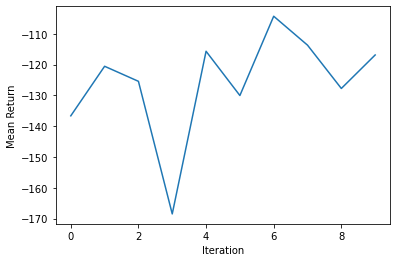

: 

In [47]:
plt.plot(test_results)
plt.xlabel('Iteration')
plt.ylabel('Mean Return')
plt.savefig('a2c_lunar.png', format='png', dpi=300)